In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BigDataAssignment1").getOrCreate()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns 

In [4]:
# Step 1: Reload data with proper delimiter and re-check schema
data = spark.read.option("header", "true").option("delimiter", ";").option("inferSchema", "true").csv("/home/bigdata/Downloads/companies.csv")
data.printSchema()
data.show(10)




root
 |-- company_number: string (nullable = true)
 |-- company_type: string (nullable = true)
 |-- office_address: string (nullable = true)
 |-- incorporation_date: string (nullable = true)
 |-- jurisdiction: string (nullable = true)
 |-- company_status: string (nullable = true)
 |-- account_type: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- sic_codes: string (nullable = true)
 |-- date_of_cessation: string (nullable = true)
 |-- next_accounts_overdue: boolean (nullable = true)
 |-- confirmation_statement_overdue: boolean (nullable = true)
 |-- owners: integer (nullable = true)
 |-- officers: integer (nullable = true)
 |-- average_number_employees_during_period: double (nullable = true)
 |-- current_assets: double (nullable = true)
 |-- last_accounts_period_end: string (nullable = true)
 |-- company_url: string (nullable = true)

+--------------+--------------------+--------------------+------------------+-------------+--------------+--------------------+-

In [5]:
row_count = data.count()
print(f"Total number of rows: {row_count}")


Total number of rows: 5428900


In [6]:
# Step 2. Data Cleaning and Transformation
# Drop duplicates
data = data.dropDuplicates()

In [7]:
# Handle missing values
# Here, we fill missing numeric values with 0 and string values with "Unknown" (modify as necessary)
data = data.fillna({"company_number": "Unknown", "incorporation_date": "Unknown", "company_status": "Unknown"})
data = data.fillna(0)  # for numeric columns

In [8]:
from pyspark.sql.functions import col

# Convert to appropriate data types as needed
data = data.withColumn("company_number", col("company_number").cast("integer"))
data = data.withColumn("incorporation_date", col("incorporation_date").cast("date"))
data = data.withColumn("last_accounts_period_end", col("last_accounts_period_end").cast("date"))

In [9]:

# Step 3. Data Analysis Using Spark SQL

# Register DataFrame as a temporary view
data.createOrReplaceTempView("company_data")

In [10]:
# Example queries for analysis
# 1. Aggregation: Summary statistics for 'current_assets'
spark.sql("SELECT AVG(current_assets) as avg_assets, STDDEV(current_assets) as stddev_assets FROM company_data").show()

+------------------+--------------------+
|        avg_assets|       stddev_assets|
+------------------+--------------------+
|184785.88557368895|3.3463218554058746E7|
+------------------+--------------------+



In [11]:
# 2. Grouping and Filtering: Group by 'company_status' and calculate average assets
spark.sql("SELECT company_status, AVG(current_assets) as avg_assets FROM company_data GROUP BY company_status").show()

+--------------------+------------------+
|      company_status|        avg_assets|
+--------------------+------------------+
|   In Administration|1421106.3084163899|
|                Open|               0.0|
|           Dissolved| 24222.90497702022|
|Voluntary Arrange...| 843816.7972709552|
|Insolvency Procee...| 938846.8463768116|
|              Active| 203061.2782901324|
|             Removed|               0.0|
|              Closed|               0.0|
|  Converted / Closed|18154.071065989847|
|          Registered|               0.0|
|     Receiver Action| 373490.2225121133|
|         Liquidation| 180670.2547085364|
+--------------------+------------------+



In [12]:
# 3. Time-based Analysis: Count companies by year of incorporation
spark.sql("SELECT YEAR(incorporation_date) AS year, COUNT(*) AS company_count FROM company_data GROUP BY year ORDER BY year").show()

+----+-------------+
|year|company_count|
+----+-------------+
|1856|            7|
|1857|            1|
|1859|            1|
|1860|            2|
|1861|            3|
|1862|            4|
|1863|            5|
|1864|           12|
|1865|            9|
|1866|            5|
|1867|            4|
|1868|            4|
|1869|            6|
|1870|            7|
|1871|           14|
|1872|           10|
|1873|           12|
|1874|           13|
|1875|           17|
|1876|           14|
+----+-------------+
only showing top 20 rows



In [13]:
# Grouping - e.g., average assets per account type
avg_assets_per_account = spark.sql("SELECT account_type, AVG(current_assets) AS avg_assets FROM company_data GROUP BY account_type")
avg_assets_per_account.show()

+--------------------+------------------+
|        account_type|        avg_assets|
+--------------------+------------------+
|   Partial Exemption| 285593.9655172414|
|                null|412.14171976265544|
|Audit Exemption S...|249816.82507367767|
|               Group|1333282.7961887142|
|No accounts type ...| 308.9353448275862|
|              Medium| 1894753.677463818|
|             Dormant|129846.00277465589|
|    Audited abridged| 1570534.102992345|
|               Small|1110690.1666092516|
|Filing Exemption ...| 24938.83378746594|
|             Initial|               0.0|
|Total Exemption Full| 325091.5284709031|
|             Interim|               0.0|
|  Unaudited abridged|358837.54373729724|
|        Micro Entity| 68863.07942598994|
|                Full|1570465.2117125092|
|                Null|39.349196838632004|
|Total Exemption S...|               0.0|
+--------------------+------------------+



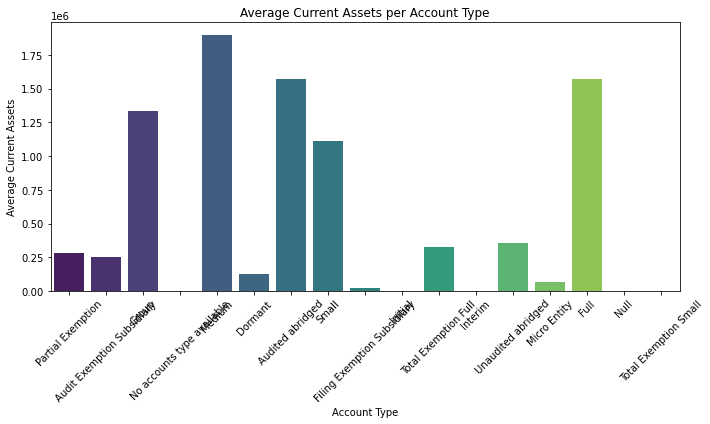

In [14]:
# Convert to Pandas DataFrame for visualization
avg_assets_per_account_pd = avg_assets_per_account.toPandas()

# Visualization of average assets per account type
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_assets_per_account_pd, x='account_type', y='avg_assets', palette='viridis')
plt.title('Average Current Assets per Account Type')
plt.xticks(rotation=45)
plt.ylabel('Average Current Assets')
plt.xlabel('Account Type')
plt.tight_layout()
plt.show()


In [15]:
# Time-based analysis - trends over time if there's a date field (e.g., incorporation_date)
time_based_analysis = spark.sql("SELECT YEAR(incorporation_date) AS year, COUNT(*) AS count FROM company_data GROUP BY year ORDER BY year")
time_based_analysis.show()


+----+-----+
|year|count|
+----+-----+
|1856|    7|
|1857|    1|
|1859|    1|
|1860|    2|
|1861|    3|
|1862|    4|
|1863|    5|
|1864|   12|
|1865|    9|
|1866|    5|
|1867|    4|
|1868|    4|
|1869|    6|
|1870|    7|
|1871|   14|
|1872|   10|
|1873|   12|
|1874|   13|
|1875|   17|
|1876|   14|
+----+-----+
only showing top 20 rows



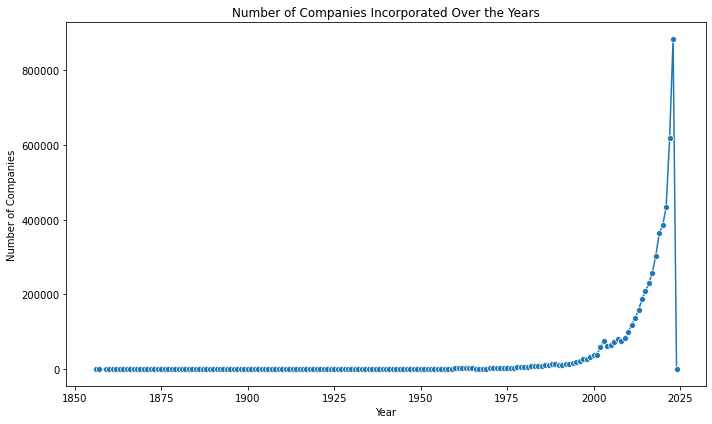

In [16]:
# Convert to Pandas DataFrame for visualization
time_based_analysis_pd = time_based_analysis.toPandas()

# Visualization of incorporation trends over the years
plt.figure(figsize=(10, 6))
sns.lineplot(data=time_based_analysis_pd, x='year', y='count', marker='o')
plt.title('Number of Companies Incorporated Over the Years')
plt.ylabel('Number of Companies')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

In [17]:
# Step 4. Machine Learning Model (Regression)

# For ML, we'll assume we want to predict 'current_assets' (Regression example)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [18]:
# Select features for regression (you may adjust these based on relevance to 'current_assets')
feature_columns = ["owners", "officers", "average_number_employees_during_period"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [19]:
# Split data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)

In [20]:
# Initialize Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="current_assets")

In [21]:
# Set up pipeline
pipeline = Pipeline(stages=[assembler, lr])


In [22]:
data.createOrReplaceTempView("data_view")


In [23]:
# Train the model
model = pipeline.fit(train_data)

In [24]:
# Make predictions on test data
predictions = model.transform(test_data)
predictions.select("features", "current_assets", "prediction").show(10)


+-------------+--------------+------------------+
|     features|current_assets|        prediction|
+-------------+--------------+------------------+
|[1.0,2.0,0.0]|         445.0|186894.60195941356|
|[1.0,1.0,0.0]|           0.0|131555.17177429542|
|[2.0,2.0,0.0]|      871994.0|260779.35298601296|
|[2.0,2.0,0.0]|           0.0|260779.35298601296|
|[2.0,2.0,0.0]|           0.0|260779.35298601296|
|[1.0,2.0,0.0]|      563565.0|186894.60195941356|
|[2.0,3.0,0.0]|           0.0| 316118.7831711311|
|[4.0,4.0,0.0]|           0.0| 519227.7154094481|
|[2.0,2.0,2.0]|     9224751.0|260779.42329778848|
|[3.0,3.0,0.0]|           0.0|390003.53419773054|
+-------------+--------------+------------------+
only showing top 10 rows



In [25]:
# Evaluate model performance
evaluator = RegressionEvaluator(labelCol="current_assets", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 11997463.587921651


In [26]:

# Step 5. Model Tuning and Evaluation

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create parameter grid for cross-validation
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()

In [27]:
# Cross-validation setup
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)


In [28]:
# Fit cross-validation model
cv_model = crossval.fit(train_data)

In [29]:
# Evaluate the best model on the test data
final_predictions = cv_model.transform(test_data)
final_rmse = evaluator.evaluate(final_predictions)
print(f"Final RMSE after tuning: {final_rmse}")

Final RMSE after tuning: 11997463.58792954
